# Imports

In [4]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType, MapType
from pyspark.ml.feature import Bucketizer
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from pyspark.sql import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

# Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/12/01 17:21:51 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.58 instead (on interface en0)
24/12/01 17:21:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 17:21:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [3]:
if local:
    # Use sample with users that have left many reviews
    game_reviews = spark.read.parquet('data/many_reviews_users_parquet')
    games = spark.read.parquet('data/steam_games_parquet')
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

# game_reviews: DataFrame = game_reviews.persist()
# games: DataFrame = games.persist()

# K-Means Clustering

In [5]:
many_reviews_users = game_reviews\
    .withColumn(
        "author_playtime_at_review",
        F.when(
            F.col("author_playtime_at_review").isNull(),
            0
        ).otherwise(
            F.col("author_playtime_at_review")
        )
    )

In [7]:
features = [
    "recommended",
    "author_num_reviews",
    "author_playtime_forever",
    "weighted_vote_score",
]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
feature_data = assembler.transform(game_reviews)

# Train KMeans model
kmeans = KMeans(k=5, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(feature_data)

# Assign clusters to users
clustered_data = model.transform(feature_data)

# Show sample cluster assignments
# clustered_data.select("author_steamid", "cluster").show()

# Analyze clusters for recommendations
# Example: Find top games in each cluster based on user reviews
top_games_per_cluster = (
    clustered_data
    .groupBy("cluster", "app_name")
    .count()
    .orderBy("cluster", "count", ascending=False)
    .groupBy("cluster")
    .agg(F.collect_list("app_name").alias("top_games"))
)

top_games_per_cluster.show(truncate=False)

# Save the model or clustered data if needed
# model.save("path_to_save_model")
# clustered_data.write.csv("path_to_clustered_data.csv", header=True)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Training KMeans for k=2


Training KMeans for k=3


Training KMeans for k=4
Training KMeans for k=5


Training KMeans for k=6


Training KMeans for k=7


Training KMeans for k=8


Training KMeans for k=9


Training KMeans for k=10


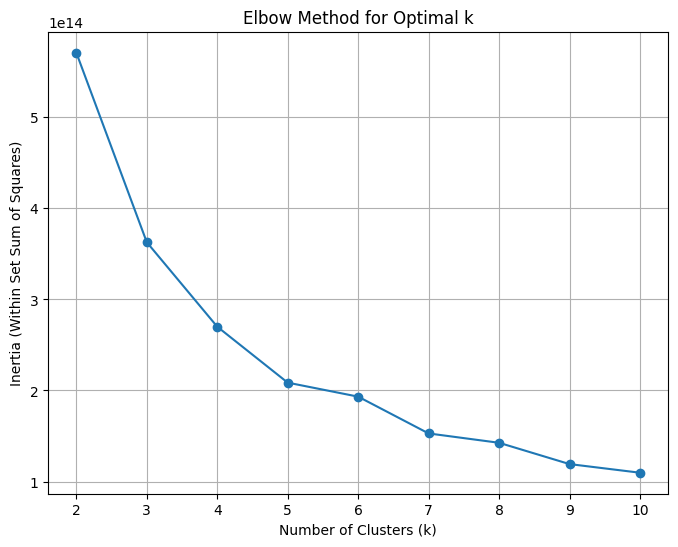

In [6]:
features = [
    "recommended",
    "author_num_reviews",
    "author_playtime_at_review",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
]
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(many_reviews_users)

# Elbow method: Compute inertia for different k values
k_values = list(range(2, 11))  # Modify range as needed
inertia = []

for k in k_values:
    print(f"Training KMeans for k={k}")
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(assembled_data)
    predictions = model.transform(assembled_data)
    
    # Compute WSSSE (Within Set Sum of Squared Errors)
    rmse_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
    silhouette = rmse_evaluator.evaluate(predictions)
    inertia.append(model.summary.trainingCost)

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within Set Sum of Squares)")
plt.grid()
plt.show()
